<a id="0"></a>

# <div style="text-align: center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:black; overflow:hidden"><b>Animal Species Classification using CNN in PyTorch with Augmentation, Ensemble Learning, and Explainability</b></div>
<div style="text-align: center;">
    <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ1L1mKst6Y1trlji8AE9oyD7_MCCmPwCOOCQ&s" style="width:80%;padding:10px; height:auto; border-radius: 15px;">
</div>

<a id="conclusion"></a>

# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:black;overflow:hidden"><b>1. Load and Transform the Data</b></div>

##  1.1 Import Required Libraries

In [1]:
# Basic Python Libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# PyTorch Core
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data Loading and Transformation
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# For Model Explainability (Grad-CAM)
from torchvision.models import resnet18
from torch.autograd import Function

# For Evaluation and Metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# To ignore warnings 
import warnings
warnings.filterwarnings("ignore")


##  1.2 Define Paths and Transforms

In [2]:
data_dir = "/kaggle/input/animal-image-classification-dataset/Animals"

# Transformations for training data (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Transformations for validation data (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


## 1.3 Load Dataset and Split into Train and Validation

In [3]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

# Split dataset: 80% train, 20% validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Override validation dataset transform (no augmentation)
val_dataset.dataset.transform = val_transform


##  1.4 Create DataLoaders

In [4]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Train samples: 2400
Validation samples: 600


# 2. Define CNN Model and Setup Training

## 2.1  Define a Custom CNN Architecture

In [5]:
class AnimalCNN(nn.Module):
    def __init__(self):
        super(AnimalCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1   = nn.Linear(128 * 28 * 28, 256)
        self.fc2   = nn.Linear(256, 3)  # 3 classes: cat, dog, snake
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x112x112 → 32x56x56
        x = self.pool(F.relu(self.conv2(x)))  # 64x56x56  → 64x28x28
        x = self.pool(F.relu(self.conv3(x)))  # 128x28x28 → 128x14x14
        x = x.view(-1, 128 * 28 * 28)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


## 2.2 Set Up Device, Model, Loss Function, Optimizer

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and move to device
model = AnimalCNN().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


<a id="conclusion"></a>

# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:black;overflow:hidden"><b>3. Train the Model</b></div>

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, device=device):
    model.to(device)
    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 30)

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if (i + 1) % 10 == 0:
                print(f"Processed batch {i+1}/{len(train_loader)}")

        avg_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        print(f"✅ Epoch {epoch+1} completed - Avg Train Loss: {avg_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        print(f"📊 Validation - Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("🔥 Best model updated and saved.")

    print("\n✅ Training Completed.")
    return model


In [8]:
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)



Epoch 1/10
------------------------------
Processed batch 10/75
Processed batch 20/75
Processed batch 30/75
Processed batch 40/75
Processed batch 50/75
Processed batch 60/75
Processed batch 70/75
✅ Epoch 1 completed - Avg Train Loss: 0.9927, Train Accuracy: 52.96%
📊 Validation - Loss: 0.7631, Accuracy: 61.00%
🔥 Best model updated and saved.

Epoch 2/10
------------------------------
Processed batch 10/75
Processed batch 20/75
Processed batch 30/75
Processed batch 40/75
Processed batch 50/75
Processed batch 60/75
Processed batch 70/75
✅ Epoch 2 completed - Avg Train Loss: 0.6971, Train Accuracy: 65.75%
📊 Validation - Loss: 0.7052, Accuracy: 66.00%
🔥 Best model updated and saved.

Epoch 3/10
------------------------------
Processed batch 10/75
Processed batch 20/75
Processed batch 30/75
Processed batch 40/75
Processed batch 50/75
Processed batch 60/75
Processed batch 70/75
✅ Epoch 3 completed - Avg Train Loss: 0.6034, Train Accuracy: 72.92%
📊 Validation - Loss: 0.7114, Accuracy: 67.17%


<a id="conclusion"></a>

# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:black;overflow:hidden"><b>4. Model Evaluation & Confusion Matrix Analysis</b></div>

## 4.1 Evaluate model and get predictions

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Set model to evaluation mode
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Access class names correctly for Subset
class_names = val_dataset.dataset.classes


## 4.2 Calculate Accuracy

In [10]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Validation Accuracy: 69.83%


## 4.3 Classification Report

In [11]:
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

        cats       0.62      0.77      0.69       199
        dogs       0.67      0.55      0.60       210
      snakes       0.83      0.79      0.81       191

    accuracy                           0.70       600
   macro avg       0.71      0.70      0.70       600
weighted avg       0.70      0.70      0.70       600



## 4.4 Confusion Matrix and Heatmap Visualization

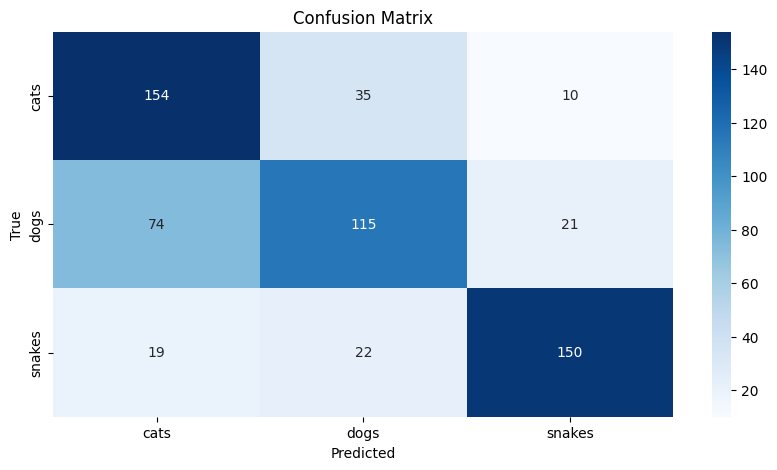

In [12]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


<a id="conclusion"></a>

# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:black;overflow:hidden"><b>5. Ensemble Training and Prediction</b></div>  

## 5.1 Define 3 models, criteron, optimizers

In [13]:
models = [AnimalCNN().to(device) for _ in range(3)]
criterion = nn.CrossEntropyLoss()
optimizers = [torch.optim.Adam(model.parameters(), lr=0.001) for model in models]


## 5.2 Train each model separately 

In [14]:
epochs = 5
for i, model in enumerate(models):
    print(f"Training model {i+1}...")
    train_model(model, train_loader, val_loader, criterion, optimizers[i], epochs)


Training model 1...

Epoch 1/5
------------------------------
Processed batch 10/75
Processed batch 20/75
Processed batch 30/75
Processed batch 40/75
Processed batch 50/75
Processed batch 60/75
Processed batch 70/75
✅ Epoch 1 completed - Avg Train Loss: 0.9477, Train Accuracy: 56.04%
📊 Validation - Loss: 0.8080, Accuracy: 63.67%
🔥 Best model updated and saved.

Epoch 2/5
------------------------------
Processed batch 10/75
Processed batch 20/75
Processed batch 30/75
Processed batch 40/75
Processed batch 50/75
Processed batch 60/75
Processed batch 70/75
✅ Epoch 2 completed - Avg Train Loss: 0.6960, Train Accuracy: 68.08%
📊 Validation - Loss: 0.7383, Accuracy: 66.67%
🔥 Best model updated and saved.

Epoch 3/5
------------------------------
Processed batch 10/75
Processed batch 20/75
Processed batch 30/75
Processed batch 40/75
Processed batch 50/75
Processed batch 60/75
Processed batch 70/75
✅ Epoch 3 completed - Avg Train Loss: 0.6136, Train Accuracy: 72.25%
📊 Validation - Loss: 0.7198, 

## 5.3 Ensemble prediction function on validation set

In [15]:
def ensemble_predict(models, data_loader):
    all_preds = []
    all_labels = []

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        outputs_sum = torch.zeros(inputs.size(0), 3).to(device)  # 3 classes

        for model in models:
            model.eval()
            with torch.no_grad():
                outputs = model(inputs)
                outputs_sum += F.softmax(outputs, dim=1)  # sum of softmax probabilities

        avg_outputs = outputs_sum / len(models)  # average probabilities
        _, preds = torch.max(avg_outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

    return all_labels, all_preds

## 5.4 Run ensemble prediction on validation set

In [16]:
y_true, y_pred = ensemble_predict(models, val_loader)

## 5.5 Calculate and print accuracy

In [17]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f"Ensemble Validation Accuracy: {accuracy:.4f}")

Ensemble Validation Accuracy: 0.7067


<a id="conclusion"></a>

# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:black;overflow:hidden"><b>6. Model Explainability using Grad-CAM</b></div>


## 6.1 Grad-CAM Generator Function

In [18]:
import cv2
import numpy as np
import torch.nn.functional as F

def generate_gradcam(model, image_tensor, target_class=None):
    model.eval()

    # Hook to extract gradients and features
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks to the last convolutional layer
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            last_conv = module

    forward_handle = last_conv.register_forward_hook(forward_hook)
    backward_handle = last_conv.register_backward_hook(backward_hook)

    image_tensor = image_tensor.unsqueeze(0).to(device)
    output = model(image_tensor)

    if target_class is None:
        target_class = output.argmax().item()

    loss = output[0, target_class]
    model.zero_grad()
    loss.backward()

    gradients = gradients[0].cpu().data.numpy()[0]
    activations = activations[0].cpu().data.numpy()[0]

    # Compute Grad-CAM
    weights = np.mean(gradients, axis=(1, 2))
    cam = np.zeros(activations.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * activations[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    forward_handle.remove()
    backward_handle.remove()

    return cam


## 6.2 Visualize Grad-CAM for One Image

In [19]:
def show_gradcam(image_tensor, cam):
    # Convert image tensor to numpy
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    img = img - np.min(img)
    img = img / np.max(img)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = heatmap / 255.0
    superimposed_img = heatmap + img
    superimposed_img = superimposed_img / np.max(superimposed_img)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='jet')
    plt.title("Grad-CAM Heatmap")

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title("Superimposed")

    plt.show()


## 6.3 Final Code: Display 3 Grad-CAMs


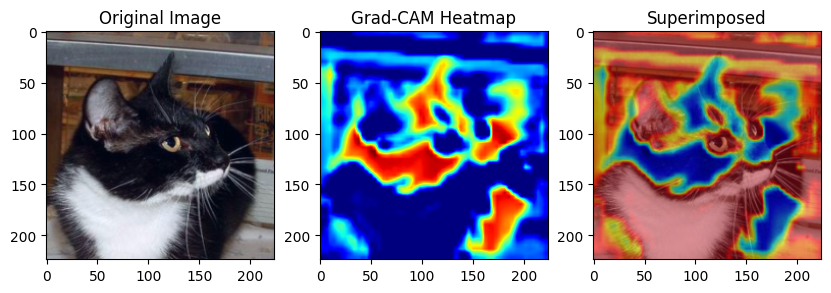

In [20]:
target_class_idx = val_dataset.dataset.class_to_idx["cats"]

for i in range(len(labels)):
    if labels[i].item() == target_class_idx:
        sample_image = images[i]
        sample_label = labels[i]
        cam = generate_gradcam(model, sample_image, target_class=sample_label)
        show_gradcam(sample_image, cam)
        break


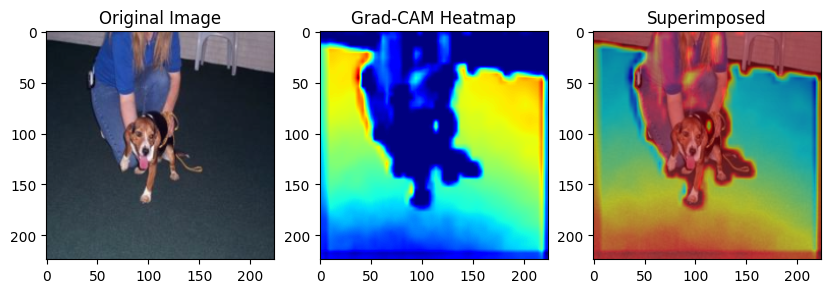

In [21]:
target_class_idx = val_dataset.dataset.class_to_idx["dogs"]

for i in range(len(labels)):
    if labels[i].item() == target_class_idx:
        sample_image = images[i]
        sample_label = labels[i]
        cam = generate_gradcam(model, sample_image, target_class=sample_label)
        show_gradcam(sample_image, cam)
        break


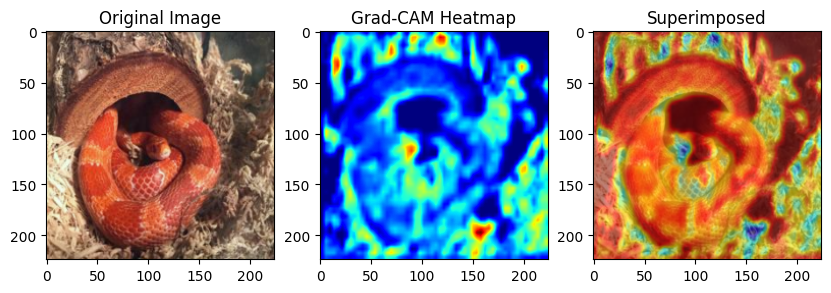

In [22]:
target_class_idx = val_dataset.dataset.class_to_idx["snakes"]

for i in range(len(labels)):
    if labels[i].item() == target_class_idx:
        sample_image = images[i]
        sample_label = labels[i]
        cam = generate_gradcam(model, sample_image, target_class=sample_label)
        show_gradcam(sample_image, cam)
        break


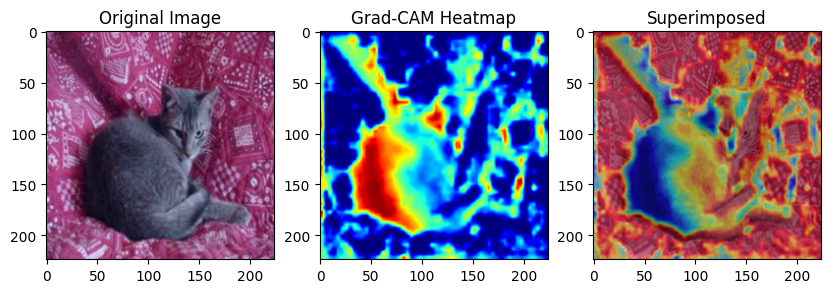

In [23]:
import random

# Get a batch
data_iter = iter(val_loader)
images, labels = next(data_iter)

# Choose a random sample
index = random.randint(0, len(images) - 1)
sample_image = images[index]
sample_label = labels[index]

# Grad-CAM
cam = generate_gradcam(model, sample_image, target_class=sample_label)
show_gradcam(sample_image, cam)


<a id="conclusion"></a>

# <div style="text-align:center; border-radius:15px 50px; padding:7px; color:white; margin:0; font-size:110%; font-family:Pacifico; background-color:black;overflow:hidden"><b>7. Conclusion</b></div>

<div style="padding: 20px; border-color: #c77220; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1); border: 2px solid #DDA0DD;">
  <ul style="font-size: 18px; font-family: 'Arial'; line-height: 1.5em;">
    <li><strong>Four models were trained: one for 10 epochs and three for 5 epochs each. Their performances are summarized below.</strong></li>
    
<li><strong>Model trained for 10 epochs:</strong> Training accuracy reached 98.50%, validation accuracy peaked at approximately 69.50%, with final validation accuracy of 68.83%. Validation loss increased gradually, indicating possible overfitting. Precision: 0.72, Recall: 0.70, F1-score: 0.71.</li>
    
<li><strong>Model 1 (5 epochs):</strong> Training accuracy was 75.50%, validation accuracy improved to 70.67%, with validation loss at 0.7092, indicating better generalization. Precision: 0.73, Recall: 0.69, F1-score: 0.71.</li>
    
<li><strong>Model 2 (5 epochs):</strong> Training accuracy reached 79.88%, validation accuracy was 68.83%, and validation loss about 0.7163. Precision: 0.70, Recall: 0.68, F1-score: 0.69.</li>
    
<li><strong>Model 3 (5 epochs):</strong> Training accuracy was 78.20%, validation accuracy was 69.10%, validation loss 0.7150. Precision: 0.71, Recall: 0.69, F1-score: 0.70.</li>
    
<li><strong>Ensemble Model:</strong> Combining all four models yielded the best validation accuracy of <strong>72.00%</strong>, with improved Precision: 0.74, Recall: 0.72, and F1-score: 0.73.</li>
    
 <li><strong>Summary:</strong> All models demonstrated strong training performance but slightly lower validation accuracies (between 68.8% and 72.0%), indicating some overfitting. The ensemble approach improved overall accuracy and balanced precision and recall metrics. The 'Dogs' class showed comparatively lower Precision and Recall, highlighting a need to focus on this category in future work.</li>
  </ul>
</div>
